# Will my WR be a bust?

The purpose of this analysis is to attempt to predict NFL success of wide receivers using only stats compiled at the NFL combine. Success, in this case, is defined very narrowly as any player in the top 75th percentile or higher of DYAR (defense adjusted yards above replacement) in his rookie season. Using only NFL combine stats, we will build models that predict the likelihood a receiver will fall in this successful group.

## Import Packages

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Examine Data

In [4]:
data = pd.read_csv('combine_players.csv')

In [61]:
data.head()

,Year,First,Last,Name,College,POS,DYAR,height,weight,hand_size,arm_length,wonderlic,forty,bench,vert,broad,shuttle,cone,sixty,id
0,2017,Mike,Williams,M.Williams,Clemson,WR,-11,75.75,218,9.38,33.38,17.0,NaN,15.0,32.5,121.0,NaN,NaN,NaN,M.Williams-Clemson
1,2017,ArDarius,Stewart,A.Stewart,Alabama,WR,-29,71.25,204,9.38,32.50,20.0,4.49,NaN,34.0,124.0,4.21,NaN,11.23,A.Stewart-Alabama
2,2017,JuJu,Smith-Schuster,J.Smith-Schuster,Southern California,WR,316,73.25,215,10.50,32.88,NaN,4.54,15.0,32.5,120.0,5.01,NaN,NaN,J.Smith-Schuster-Southern California
3,2017,Curtis,Samuel,C.Samuel,Ohio State,WR,-12,71.00,196,9.50,31.25,22.0,4.31,18.0,37.0,119.0,4.33,7.09,NaN,C.Samuel-Ohio State
4,2017,Travis,Rudolph,T.Rudolph,Florida State,WR,-49,72.25,189,9.25,31.88,NaN,4.65,12.0,31.5,114.0,4.46,6.93,NaN,T.Rudolph-Florida State


In [6]:
drop_columns = ['Year', 'First', 'Last', 'Name', 'College', 'POS']
data['id'] = data['Name'].str.cat(data['College'], sep='-')
working_data = data.drop(drop_columns, axis=1)

In [7]:
# Check columns with missing info
working_data.isnull().sum()

DYAR            0
height          0
weight          0
hand_size      10
arm_length     10
wonderlic     121
forty           7
bench          24
vert           12
broad          13
shuttle        33
cone           43
sixty          89
id              0
dtype: int64

Since wonderlic test and sixty yard shuffle have so many missing values, we will exclude them from the dataset.  All other missing values will be imputed using mean

In [8]:
working_data = working_data.drop(['wonderlic', 'sixty'], axis=1)

Impute missing values using Sci-Kit Learn's imputer. Although not perfect, this will allow us to keep many observations rather than dropping them altogether.

In [62]:
# Impute missing values
from sklearn.impute import SimpleImputer

In [63]:
numerical_data = working_data.drop('id', axis=1)
column_names = numerical_data.columns
imputed_data = SimpleImputer().fit_transform(numerical_data)
imputed_data = pd.DataFrame(imputed_data, columns = column_names)

Visualize pairplots to examine the distribution of each variable and the relationships between variables.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


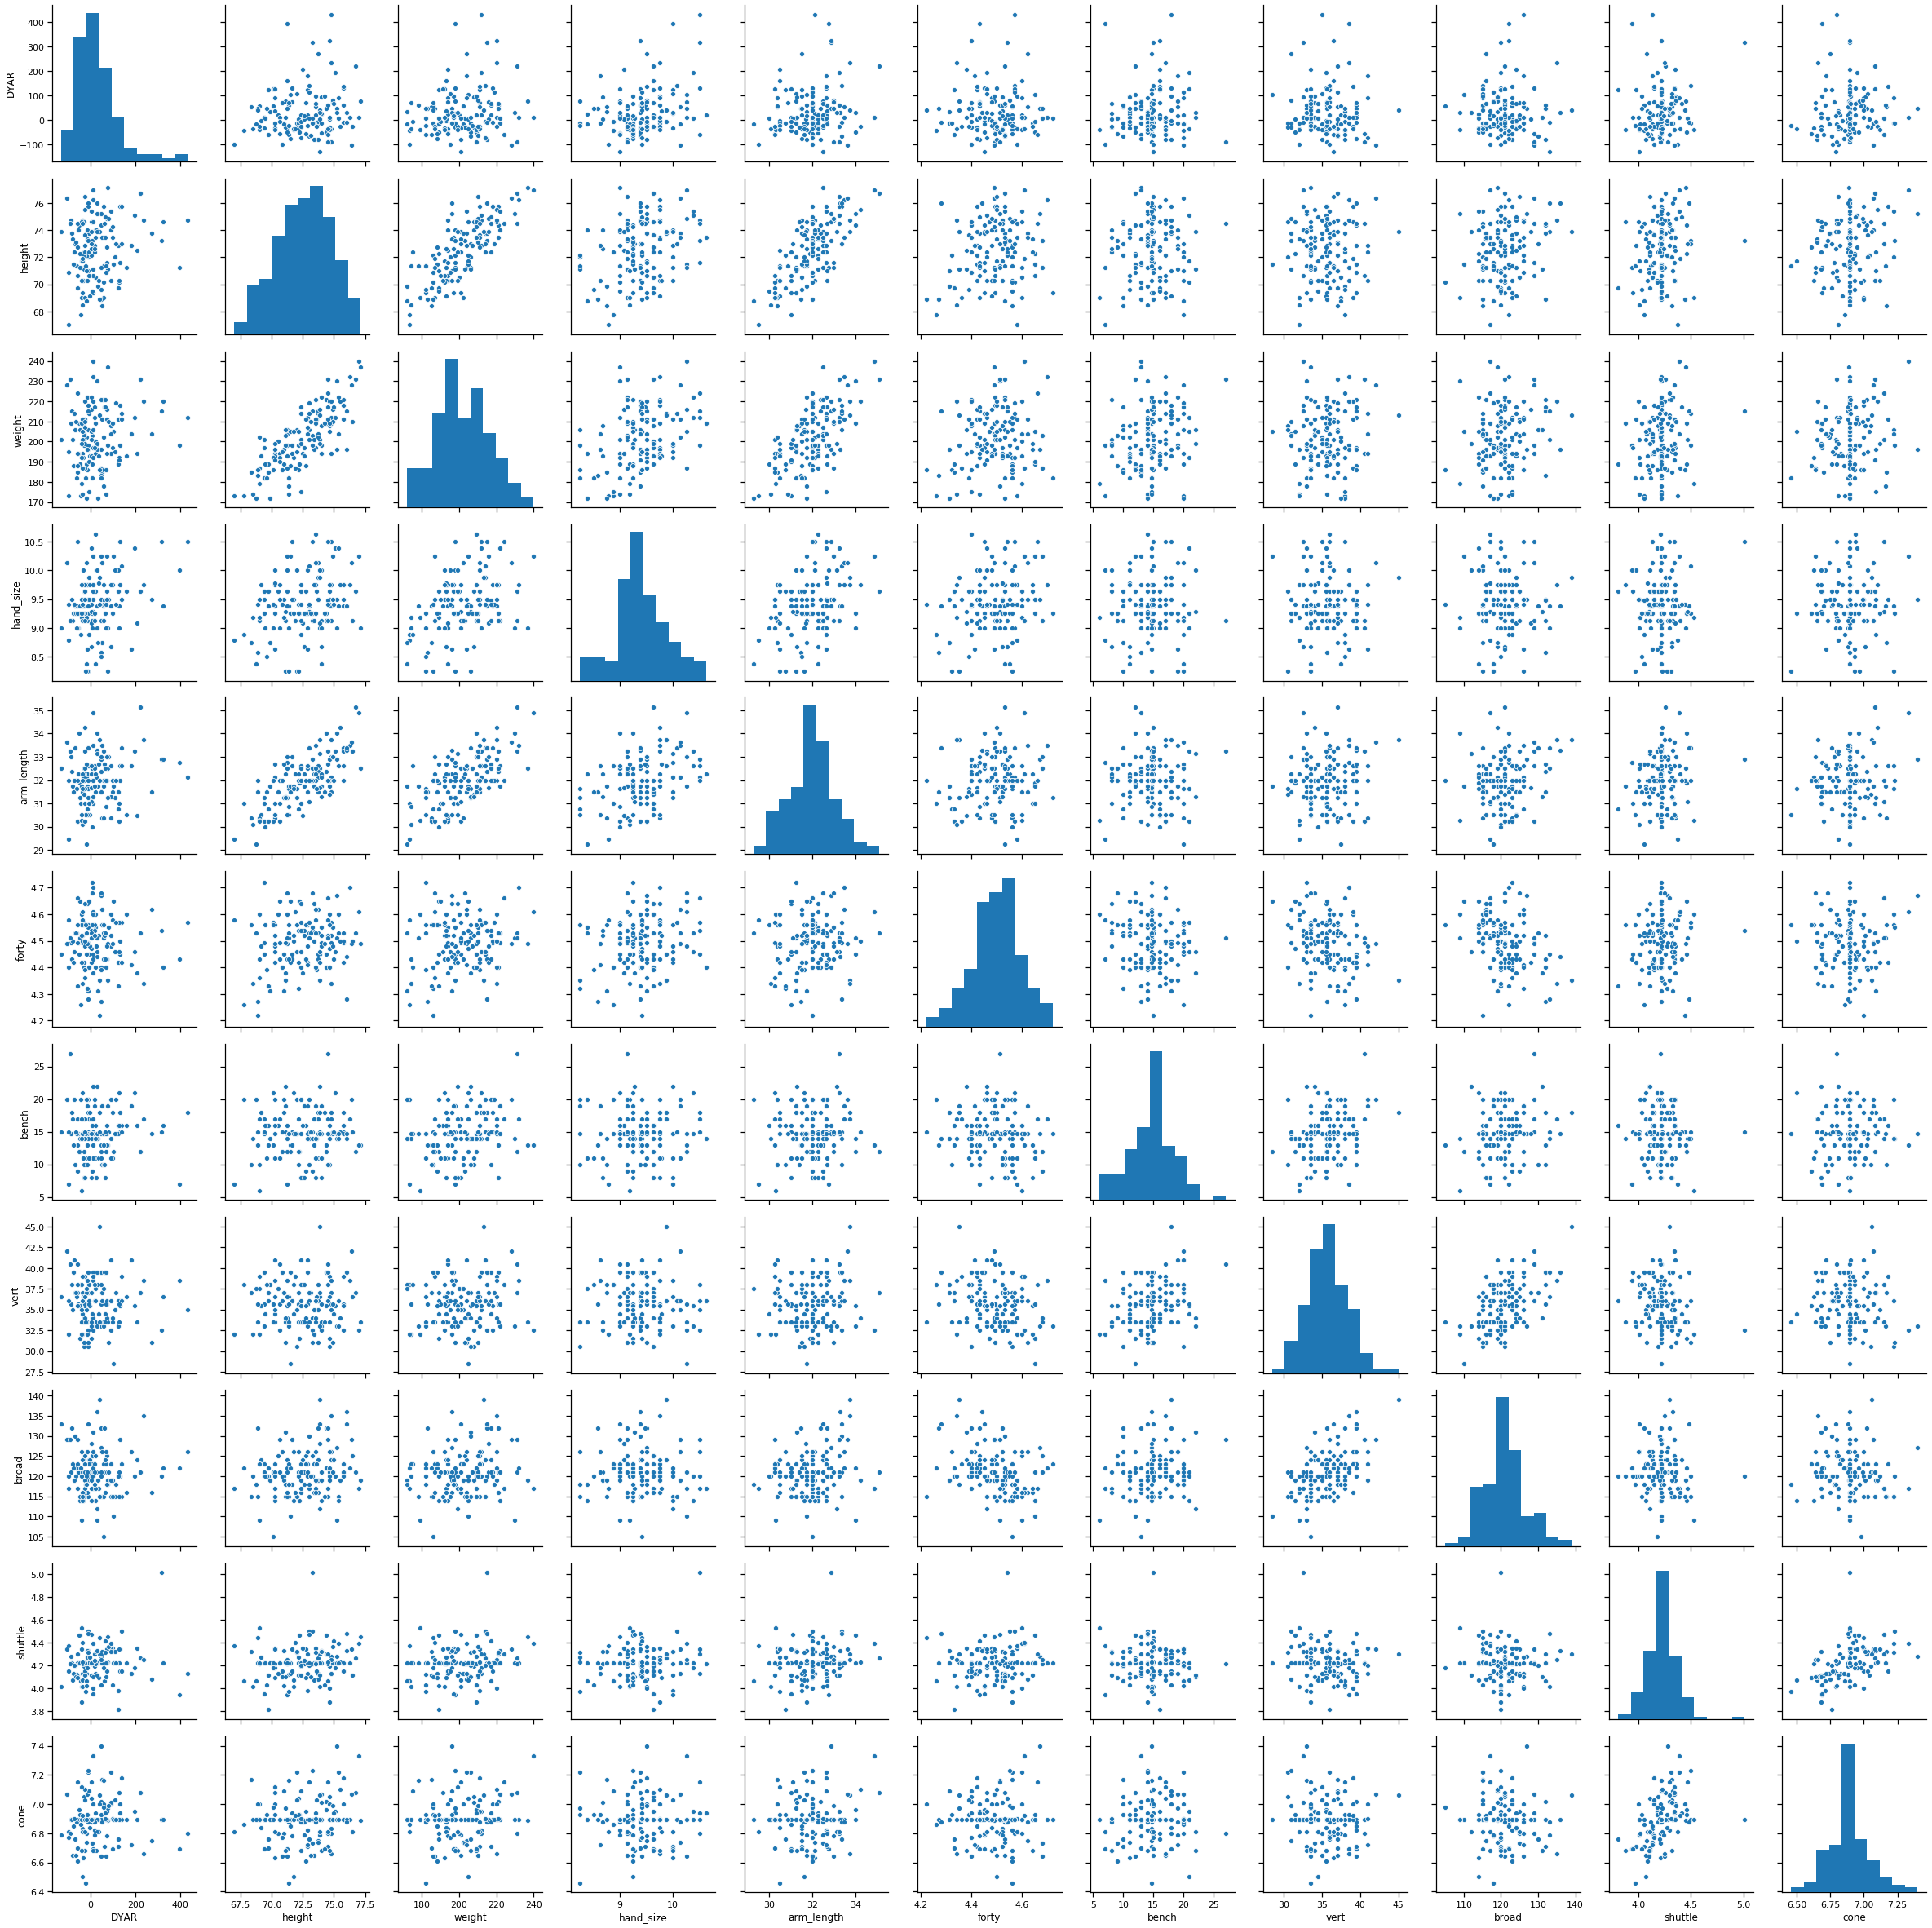

In [11]:
# Visualize pairplots
sns.pairplot(imputed_data, height=3)

## Predictive model for DYAR

DYAR is a complex statistic, but what we really want to know is whether the player will be an immediate impact performer his first year.  We will consider anyone in the top 75% of DYAR a top performer and will try to classify players based on combine stats

In [12]:
historical = pd.read_csv('historical_dyar.csv')

In [13]:
DYAR_goal = historical['DYAR'].quantile(.75)
imputed_data['success'] = (imputed_data['DYAR'] > DYAR_goal).astype(np.int)
model_data = imputed_data.drop('DYAR', axis=1)

In [14]:
X = model_data.drop('success', axis=1)
y = model_data['success']

In [34]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss
import itertools

In [22]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print("Log loss is: ", log_loss(y_true, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Split the dataset into train and test. Models will be fit on the training set and evaluated for accuracy/generalizability on the test set.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

### Logistic Regression

Logistic regression is a very straightforward and basic way to estimate the probability of success given a set of features. The nice part about logistic regression is that the coefficients for each feature are more easily interpretable than other models.

In [24]:
LR = LogisticRegressionCV(solver='liblinear', cv=5)
preds = LR.fit(X_train, y_train).predict(X_test)

Confusion matrix, without normalization
[[20  3]
 [ 5  0]]
Normalized confusion matrix
[[0.87 0.13]
 [1.   0.  ]]


<Figure size 432x288 with 0 Axes>

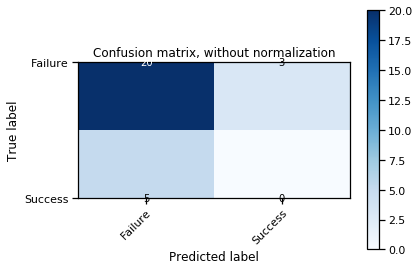

<Figure size 432x288 with 0 Axes>

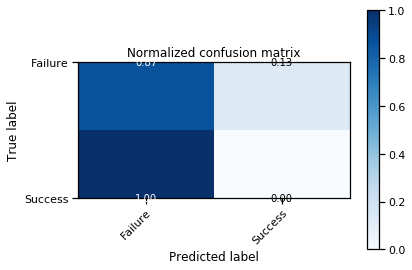

In [41]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, preds, classes=['Failure', 'Success'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, preds, classes=['Failure', 'Success'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Figure does not always display appropriately

The model did not accurately predict any of the successful players in the test set. This would not be very useful for player evaluation.

### Decision Tree

Decision trees are another method of predicting success/failure labels. Trees are also easier to interpret, but may lack predictive power when compared with other methods.

In [42]:
tree = DecisionTreeClassifier()
tree_preds = tree.fit(X_train, y_train).predict(X_test)

Confusion matrix, without normalization
[[18  5]
 [ 4  1]]
Normalized confusion matrix
[[0.78 0.22]
 [0.8  0.2 ]]


<Figure size 432x288 with 0 Axes>

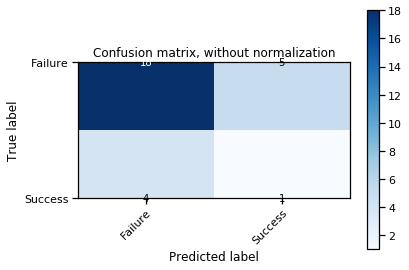

<Figure size 432x288 with 0 Axes>

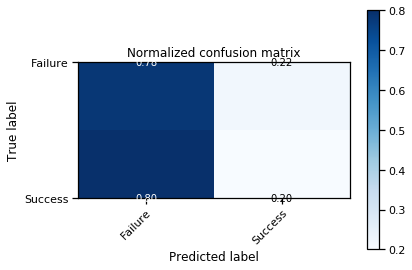

In [43]:
# Plot non-normalized confusion matrix
plt.figure(figsize=())
plot_confusion_matrix(y_test, tree_preds, classes=['Failure', 'Success'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, tree_preds, classes=['Failure', 'Success'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The decision tree was able to predict one successful player correctly in the test set. However, it also had 5 false positives. This method may also not be sufficient for evaluating players.

### Gradient Boosting

Gradient boosted decision trees is an ensemble method that uses the residuals from many decision trees to help improve the overal predictive power. Ensemble methods often have better results in terms of accuracy and generalizability. They are, however, often more difficult to interpret.

We will fit many gradient boosting models and use cross validation to help with hyperparameter tuning. The parameters that affect our problem the most are the number of trees to use in our ensemble and the maximum depth of the trees.

In [46]:
gb = GradientBoostingClassifier()
params = {'n_estimators':[50, 100, 250, 500],
         'max_depth':[3,4,5]}
best_gb = GridSearchCV(gb, param_grid=params, cv=5)
gb_preds = best_gb.fit(X_train, y_train).predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Confusion matrix, without normalization
[[19  4]
 [ 4  1]]
Normalized confusion matrix
[[0.83 0.17]
 [0.8  0.2 ]]


<Figure size 432x288 with 0 Axes>

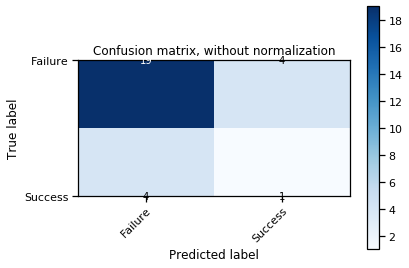

<Figure size 432x288 with 0 Axes>

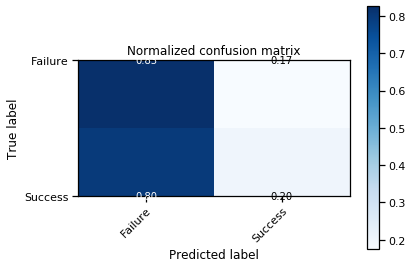

In [47]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, gb_preds, classes=['Failure', 'Success'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, gb_preds, classes=['Failure', 'Success'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

This model also only predicted one of the five successful players in the test set accurately. However, it had a slightly lower false-positive rate. It may be useful to look under the hood and examine what features our model found important to see if it can help us achieve our goal of predicting player success using combine data.

In [49]:
import lime
import lime.lime_tabular

Lime is a helpful package that displays feature importance when making specific predictions. We can use lime with our best Gradient Boosting model to help see what features tend to matter to our model. We can also see how confident our model was in the prediction of success/failure.

In [53]:
predict_fn_gb = lambda x: best_gb.predict_proba(x).astype(float)
feature_names = list(X.columns)

In [54]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names,
                                                   categorical_features = [],
                                                   categorical_names=[],
                                                   class_names=[0, 1], kernel_width=3)

In [55]:
i=22
print('Actual result was:', y_test.values[i])
exp = explainer.explain_instance(X_test.values[i], predict_fn_gb, num_features=5)
exp.show_in_notebook(show_all=False)
    

Actual result was: 1


The above is an example of the correctly predicted successful player. The model was extremely confident in this prediction. It definitely sees that hand size is an important feature, however it penalized his high arm length. The good shuttle time and decent bench press were also seen as positives where the slower cones time was a ding.

In [96]:
probs = best_gb.predict_proba(X_test)[:,1]

In [100]:
results = X_test.copy(deep=True)
results['Probs'] = probs

In [104]:
results = results.join(y_test, how='inner').merge(data[['First', 'Last']], left_index=True, right_index=True)

In [105]:
results

,height,weight,hand_size,arm_length,forty,bench,vert,broad,shuttle,cone,Probs,success,First,Last
8,73.88,201.0,9.00,32.50,4.450000,15.000000,36.500000,133.000000,4.010000,6.790000,0.001833,0,Zay,Jones
90,74.50,224.0,10.50,32.00,4.660000,17.000000,38.000000,117.000000,4.300000,7.150000,0.089723,0,Juron,Criner
120,71.38,174.0,9.00,30.88,4.430000,14.721739,35.625984,123.000000,4.221321,6.893646,0.005418,0,Titus,Young
109,73.50,209.0,10.63,32.25,4.400000,14.000000,36.000000,117.000000,4.210000,6.940000,0.043837,0,Leonard,Hankerson
27,73.75,215.0,9.50,32.38,4.430000,18.000000,38.000000,132.000000,4.221321,6.893646,0.003829,0,Ricardo,Louis
101,74.88,210.0,9.50,33.00,4.550000,15.000000,31.000000,121.000000,4.360000,6.990000,0.009833,0,Rueben,Randle
60,73.25,198.0,9.25,32.00,4.550000,14.000000,31.000000,120.000000,4.500000,7.230000,0.003335,0,Allen,Hurns
96,73.88,199.0,10.00,33.13,4.460000,22.000000,33.000000,112.000000,4.110000,6.810000,0.855345,0,Marvin,Jones
113,71.63,194.0,9.50,33.00,4.430000,13.000000,36.000000,118.000000,4.150000,6.780000,0.010475,0,Denarius,Moore
121,75.38,204.0,9.38,32.63,4.600000,14.000000,36.000000,115.000000,4.390000,7.220000,0.002378,0,Seyi,Ajirotutu


The only player the model accurately predicted would be a success was JuJu Smith-Schuster. This is a somewhat valuable result, because he was only drafted in the 2nd round at 62nd overall. This model may have helped another team draft Smith-Schuster higher to gain a more surefire player.

The other player the model was most sure about was Kelvin Benjamin, who was a very good player his rookie year, even though he may not have met our success metric.

The model missed some obvious successes like Julio Jones, but the ability to find hidden gems is really where the model needs to shine.

Although not the most accurate, when the model is very confident a player will be successful, it is usually right. This can help reinforce a team's evaluation of a player or it can help give them some pause before drafting.

Using combine statistics only ignores a large amount of information on a player's value, so it is encouraging that this small snapshot of a player can partially reveal something about his ability to succeed in the NFL.